Iris dataset contains 5 features. 

Attribute Information: 

    sepal length,
    sepal width,
    petal length,
    petal width,
    class - there are three classes: Iris-Setosa \ Iris-Versicolour \ Iris-Virginica.

Problem is to find class of iris based on its features.

Classes are presented as indices:

1 - Iris-Setosa, 

2 - Iris-Versicolour, 

3 - Iris-Virginica.

Iris features are numerical, class is categorical.

In [56]:
%matplotlib inline
import pandas as pd
from random import shuffle
from sklearn import datasets
import scipy.stats as scp
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score
from IPython.display import display

In [2]:
random.seed(0)
iris = datasets.load_iris()
features = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]

In [3]:
#print iris.target_names
#print iris.data[0:5]
#print iris.target[0:5]

Lets split data to training and testing sets for future analysis.

In [4]:
s = np.arange(iris.data.shape[0])
np.random.shuffle(s)

trainD = iris.data[s][:120]
trainT = iris.target[s][:120]

testD = iris.data[s][120:]
testT = iris.target[s][120:]

Creation DataFrame which consists is helpful in showing basic information about dataset

In [18]:
df_trainD = pd.DataFrame(trainD, columns=features)
#df_trainD.head()
df_trainD.describe()

,Sepal Length,Sepal Width,Petal Length,Petal Width
count,120.000000,120.000000,120.000000,120.000000
mean,5.805833,3.062500,3.630000,1.140000
std,0.834175,0.440218,1.786626,0.767775
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.500000,0.275000
50%,5.700000,3.000000,4.200000,1.300000
75%,6.400000,3.400000,5.100000,1.800000
max,7.900000,4.400000,6.700000,2.500000


In [19]:
#eda = {}

#for x in range(4):
#    eda[features[x]]={}
#    eda[features[x]]["mean"] = np.mean(trainD[:,x])
#    eda[features[x]]["min"] = np.amin(trainD[:,x])
#    eda[features[x]]["max"] = np.amax(trainD[:,x])
#    eda[features[x]]["median"] = np.median(trainD[:,x])
#    eda[features[x]]["mode"] = scp.mode(trainD[:,x])
#    eda[features[x]]["std"] = np.std(trainD[:,x])

#dfEDA = pd.DataFrame(data=eda)    

Lets create normalised histograms of each feature with overlay on target feature.

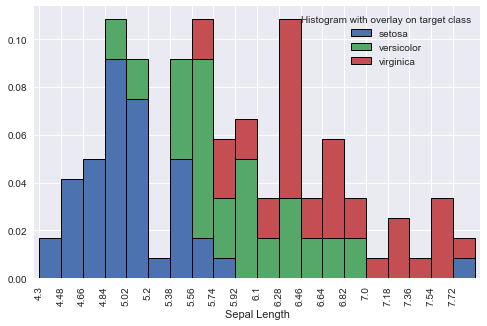

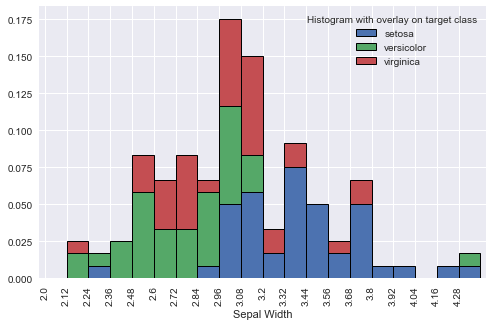

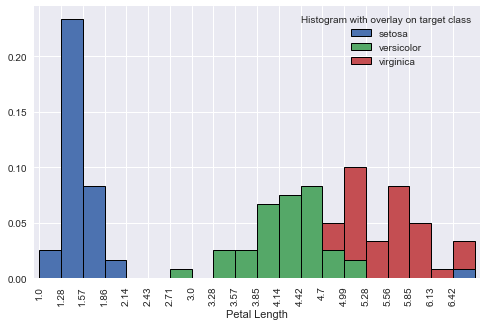

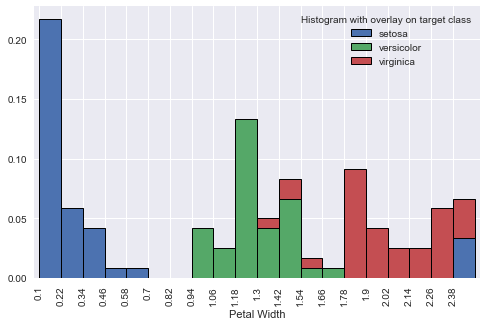

In [20]:
def closest(clusters, val):
    if val > min(clusters, key=lambda z:abs(z-n)):
        return min(clusters, key=lambda z:abs(z-n))
    else:
        return clusters[clusters.index(min(clusters, key=lambda z:abs(z-n)))-1]


for x in range(4):
    bins=20
    step = (df_trainD[features[x]].max() - df_trainD[features[x]].min()) / bins
    clusters =[round(df_trainD[features[x]].min()+(step*n),2) for n in range(bins)]
    
    d = {n: {0:0, 1:0, 2:0} for n in clusters}

    for n,m in zip(trainD[:,x], trainT):
        d[closest(clusters, n)][m] += 1

    df= pd.DataFrame(data=d)
    normalizer = lambda x: x/len(trainT)
    df = df.apply(normalizer)
    df = df.transpose()
    df.columns = iris.target_names
    df.columns.name = 'Histogram with overlay on target class'
    df.index.name = features[x]
    df.plot(kind='bar', position=0, width=1.0, edgecolor='black', linewidth=1.0, stacked=True, 
            figsize = (8,5), fontsize = 10)


Thanks to histograms we can notice a few things:

Petal Width and Petal Length seem to splitted in three groups. Lower values describe "Setosa", middle ones "Versicolor", and higher ones "Virginica".

Sepal Width's mode is 3.0, and mean is 3.08583 what you can notice on the histogram. "Setosa" class seems to have values greater than 3, and "Versicolor" lower than 3.2. "Virginica" varies, but seems to not having the highest or the lowest values.

Sepal Length seems to be more or less divided into three groups.

Check if some features are correlated with each other. For this purpose create correlation graph.

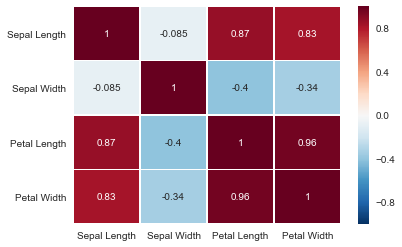

In [21]:
corr = np.corrcoef([trainD[:,0], trainD[:,1],trainD[:,2],trainD[:,3]])
dfCORR = pd.DataFrame(data=corr, columns = features, index = features)
 
sns.heatmap(dfCORR, linewidths=0.5, annot=True)

As you we can notice, there is very strong linear correlation between Petal Width and Petal Length. There is also  strong positive correlation between Sepal Length and Petal Length or Petal Width. There is weak negative correlation between Sepal Width and Petal Length or Petal Width. And there is no correlation between Sepal Length and Sepal Width. Those results can be used in PCA.

According to the correlation graph it seems to be linear correlation between Petal Width and Petal Length (you can check other features - uncomment code with permutations). 

We can create prediction model. It will tell us Petal Length for given Petal Width and opposite. We can choose linear regression or polynomial regression. For this purpose we have splitted data for Train and Test sets. Firstly we create regression models basen od Train data, and then we check if models follow position of points in Test data. 

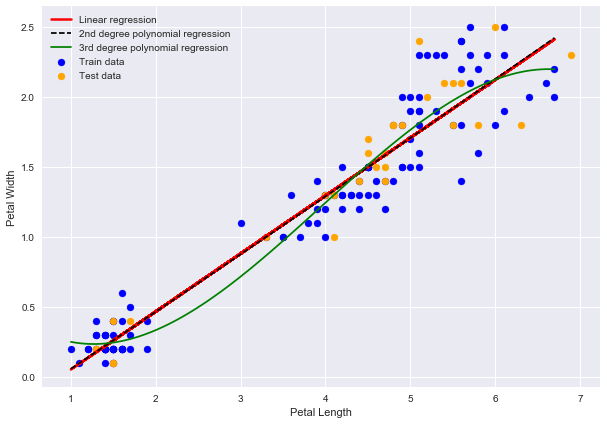

In [22]:
def predict(x,y, nlog=False):
    
    if nlog==True:
        n=np.log(trainD[:,x])
        m=np.log(trainD[:,y])
        j=np.log(testD[:,x])
        k=np.log(testD[:,y])
        xp = np.linspace(np.log(df_trainD[features[x]].min()), np.log(df_trainD[features[x]].max()), 100)
    elif nlog==False:
        n=trainD[:,x]
        m=trainD[:,y]
        j=testD[:,x]
        k=testD[:,y]
        xp = np.linspace(df_trainD[features[x]].min(), df_trainD[features[x]].max(), 100)
    else:
        return "nlog can be True or False"
        
    
    slope, intercept, r_value, p_value, std_err = scp.linregress(n, m)

    p1 = slope * n + intercept
    p2 = np.poly1d(np.polyfit(n, m, 2))
    p3 = np.poly1d(np.polyfit(n, m, 3))

    plt.figure(figsize=(10,7))
    plt.xlabel(features[x])
    plt.ylabel(features[y])

    plt.plot(n, p1, 'r', linewidth=2.5, label="Linear regression")
    plt.plot(xp, p2(xp), c='black', ls='--', label="2nd degree polynomial regression" )
    plt.plot(xp, p3(xp), c='g', label="3rd degree polynomial regression")
    plt.scatter(n, m, c='b', label="Train data")
    plt.scatter(j, k, c='orange', label="Test data")
    plt.legend()    
    
predict(2,3)


As we can see there is not much difference between each regression. Moreover Higher degrees regressions don't seem to fit better Test data. According to the results we can choose linear regression to be prediction model.

We can apply nlogarithm, to create better model.

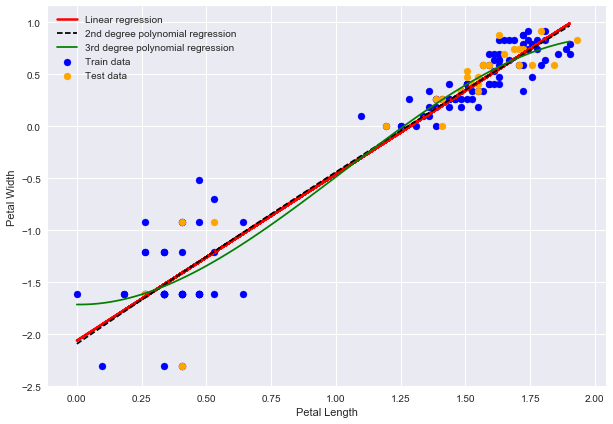

In [23]:
predict(2,3,True)

With PCA we can take features which contain the highest value of variance and represent data only on chosen features. As we can notice below, one feature contains variance much higher than other ones. So we can probably take two features and plot data in 2D with new features based on the previous ones.

0.690049305556
0.192177083333
3.16543333333
0.584566666667


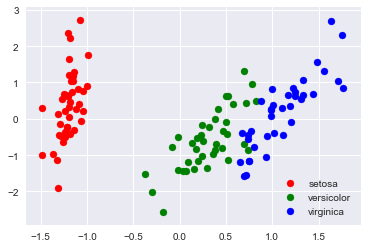

In [24]:
for x in range(4):
    print (np.var(trainD[:,x]))

pca = PCA(n_components=2, whiten=True).fit(trainD)
X_pca = pca.transform(trainD)

colors =['r','g','b']
target_ids = range(len(iris.target_names))
plt.figure()

for i, c, label in zip(target_ids, colors, iris.target_names):
    plt.scatter(X_pca[trainT == i, 0], X_pca[trainT == i, 1], 
        c=c, label=label)
plt.legend()
plt.show()

KMeans is algorithm that make clusters from the points of dataset. For the purpose of this exercise I will take output points of PCA. So we could compare results of KMeans with default clusters of points.

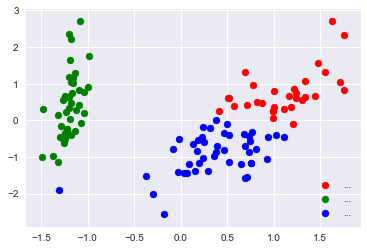

In [28]:
model = KMeans(n_clusters=3, n_init =50)

model = model.fit(scale(X_pca))

#print (X_pca)
#print (model.labels_)
#print (trainT)

plt.figure()
for i, c, label in zip(target_ids, colors, iris.target_names):
    plt.scatter(X_pca[model.labels_ == i, 0], X_pca[model.labels_ == i, 1], 
        c=c, label='...')
plt.legend()
plt.show()

As we can notice KMeans grouped classes of flowers in different groups. KMeans creates groups with the closest distances to the mean points. So it is not good clustering method for this case. Without knowlegde of three classes of iris flowers we could create 4,5 or more classes with divided points.

Final classification with Random Forest Classifier. 28/30 samples were predicted correctly.

array([[ 6,  0,  0],
       [ 0, 10,  1],
       [ 0,  1, 12]])

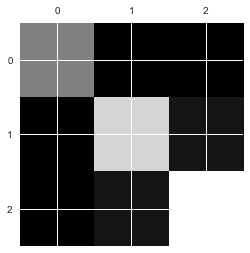

In [55]:
forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(trainD, trainT)
final_predictions = forest_clf.predict(testD)

conf_mx = confusion_matrix(testT, final_predictions)
display(conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)